# Machine Learning Modelling

## Hotel Booking - Price Prediction

### Import Libraries

In [84]:
# General
import numpy as np
import pandas as pd

# EDA
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
colour_palette = sns.color_palette("hls", 8)

# # Regression 
# import statsmodels.api as sm
# import statsmodels.formula.api as smf                 # for ols and logit
# # from statsmodels.multivariate.pca import PCA

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler      # Remove Mean and scale to Unit Variance
from sklearn.preprocessing import PowerTransformer    # Log Transformation
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

### Pre-Processing

In [85]:
## Importing Data
data_hotel_bookings = pd.read_csv('../../Dataset/hotel_booking/hotel_bookings.csv')

## Understanding Data I
data_hotel_bookings.describe()
data_hotel_bookings


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [86]:
## Understanding Data II
print(data_hotel_bookings.dtypes)

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [87]:
## Check Missing Data
data_hotel_bookings.isnull().sum()[data_hotel_bookings.isnull().sum() > 0]

children         4
country        488
agent        16340
company     112593
dtype: int64

In [88]:
## Fill Missing Data

# For Children
data_hotel_bookings.children.fillna(0, inplace = True)

# For Country
data_hotel_bookings.country.fillna("Unknown", inplace = True)

# For Agent
data_hotel_bookings.loc[data_hotel_bookings.agent.isnull() == False, 'agent'] = 'Agent'
data_hotel_bookings.agent.fillna("No Agent", inplace = True)

# For Company 
data_hotel_bookings.loc[data_hotel_bookings.company.isnull() == False, 'company'] = 'Corporate'
data_hotel_bookings.company.fillna("No Company", inplace = True)

# Re-Confirm 
data_hotel_bookings.isnull().sum()[data_hotel_bookings.isnull().sum() > 0]

Series([], dtype: int64)

In [89]:
## Cleaning Data
data_hotel_bookings_resort = data_hotel_bookings.loc[data_hotel_bookings["hotel"] == "Resort Hotel"]
data_hotel_bookings_city = data_hotel_bookings.loc[data_hotel_bookings["hotel"] == "City Hotel"]

### Feature Engineering

In [90]:
# create categories for the days_in_waiting_list column (1: 0-10days, 2: 11-20days, 3: 21-30days...)
bins = [-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
data_hotel_bookings['days_in_waiting_list_category'] = pd.cut(data_hotel_bookings['days_in_waiting_list'], bins=bins, labels=labels)

# print the result
data_hotel_bookings[['days_in_waiting_list', 'days_in_waiting_list_category']].max()

days_in_waiting_list             391
days_in_waiting_list_category     15
dtype: int64

In [93]:
## LabelEncoder / OneHotEncoder

# OneHotEncoder (Run Once only)

# # perform one-hot encoding for the customer_type column
# customer_type_one_hot = pd.get_dummies(data_hotel_bookings['customer_type'], prefix='customer_type')
# # concatenate the one-hot encoded columns to the original dataset
# data_hotel_bookings = pd.concat([data_hotel_bookings, customer_type_one_hot], axis=1)
# # drop the original customer_type column
# data_hotel_bookings.drop('customer_type', axis=1, inplace=True)

# # perform one-hot encoding for the market_segment column
# market_segment_one_hot = pd.get_dummies(data_hotel_bookings['market_segment'], prefix='market_segment')
# # concatenate the one-hot encoded columns to the original dataset
# data_hotel_bookings = pd.concat([data_hotel_bookings, market_segment_one_hot], axis=1)
# # drop the original customer_type column
# data_hotel_bookings.drop('market_segment', axis=1, inplace=True)

# # perform one-hot encoding for the distribution_channel column
# distribution_channel_one_hot = pd.get_dummies(data_hotel_bookings['distribution_channel'], prefix='distribution_channel')
# # concatenate the one-hot encoded columns to the original dataset
# data_hotel_bookings = pd.concat([data_hotel_bookings, distribution_channel_one_hot], axis=1)
# # drop the original customer_type column
# data_hotel_bookings.drop('distribution_channel', axis=1, inplace=True)


# LabelEncoder

# create a LabelEncoder object
le = LabelEncoder()

# apply LabelEncoder to the reservation_status column ('Canceled': -1, 'No-Show': 0, 'Check-Out': 1)
mapping_rs = {'Canceled': -1, 'No-Show': 0, 'Check-Out': 1}
data_hotel_bookings['reservation_status'] = data_hotel_bookings['reservation_status'].map(mapping_rs)
data_hotel_bookings['reservation_status'] = le.fit_transform(data_hotel_bookings['reservation_status'])
data_hotel_bookings['reservation_status'] = data_hotel_bookings['reservation_status'].map(dict(zip(range(3), mapping_rs.values())))

# apply LabelEncoder to the deposit_type column ('Non-Refund': -1, 'No Deposit': 0, 'Refundable': 1)
mapping_dt = {'Non Refund': -1, 'No Deposit': 0, 'Refundable': 1}
data_hotel_bookings['deposit_type'] = data_hotel_bookings['deposit_type'].map(mapping_dt)
data_hotel_bookings['deposit_type'] = le.fit_transform(data_hotel_bookings['deposit_type'])
data_hotel_bookings['deposit_type'] = data_hotel_bookings['deposit_type'].map(dict(zip(range(3), mapping_dt.values())))

# print the result
data_hotel_bookings

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,1,0,0,0,0,0,1,0,0,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,1,0,0,0,0,0,1,0,0,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,1,0,0,0,0,0,1,0,0,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,0,0,0,0,1,0,0,0,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,0,0,1,0,0,0,0,0,1,0
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,0,0,0,1,0,0,0,0,1,0
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,0,0,0,1,0,0,0,0,1,0
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,0,0,0,1,0,0,0,0,1,0


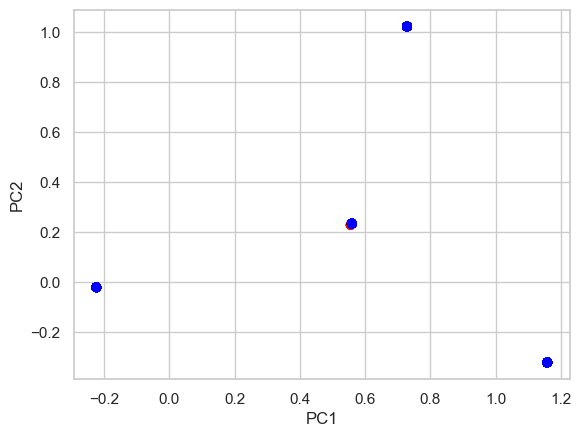

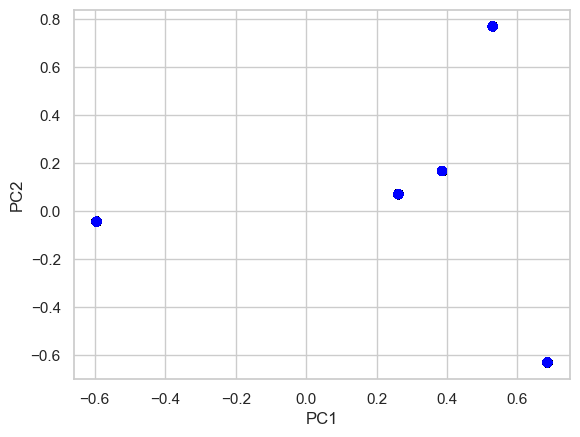

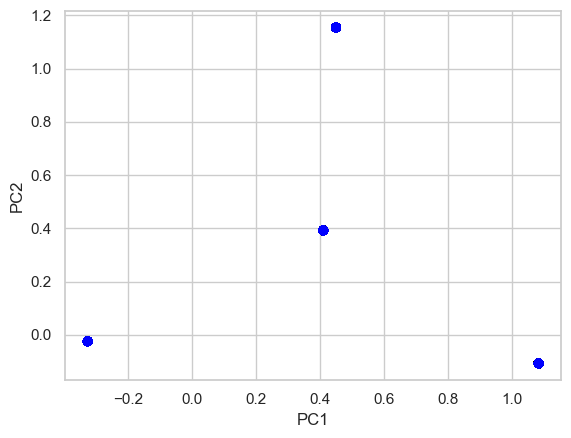

Explained variance ratios: [4.82358387e-01 2.65894036e-01 2.51747578e-01 1.99771495e-31]


In [113]:
## Principal Component Analysis (PCA)

# Select variables for PCA
X = data_hotel_bookings[['distribution_channel_Corporate', 'distribution_channel_Direct', 'distribution_channel_GDS', 'distribution_channel_TA/TO', 'distribution_channel_Undefined']]

# Add cancellation status as target variable
y = data_hotel_bookings['is_canceled']

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create scatter plot of first two principal components
colors = ['red' if x == 1 else 'blue' for x in y]
plt.scatter(X_pca[:,0], X_pca[:,1], c=colors)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


# Select variables for PCA
X = data_hotel_bookings[['market_segment_Direct', 'market_segment_Groups', 'market_segment_Offline TA/TO', 'market_segment_Online TA', 'market_segment_Undefined']]

# Add cancellation status as target variable
y = data_hotel_bookings['is_canceled']

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create scatter plot of first two principal components
colors = ['red' if x == 1 else 'blue' for x in y]
plt.scatter(X_pca[:,0], X_pca[:,1], c=colors)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()



# Select variables for PCA
X = data_hotel_bookings[['customer_type_Transient', 'customer_type_Transient-Party', 'customer_type_Group', 'customer_type_Contract']]

# Add cancellation status as target variable
y = data_hotel_bookings['is_canceled']

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create scatter plot of first two principal components
colors = ['red' if x == 1 else 'blue' for x in y]
plt.scatter(X_pca[:,0], X_pca[:,1], c=colors)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

X = StandardScaler().fit_transform(X)

pca = PCA()
principalComponents = pca.fit_transform(X)

explained_var = pca.explained_variance_ratio_
print("Explained variance ratios:", explained_var)

In [96]:
## Correlation Matrix
data_hotel_bookings.corr()

/var/folders/g_/02jbqh790tj4qzrwy17x87c00000gn/T/ipykernel_51308/2284939715.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_hotel_bookings.corr()


,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined
is_canceled,1.000000,0.293123,0.016660,0.008148,-0.006130,-0.001791,0.024765,0.060017,0.005036,-0.032491,...,-0.154390,0.221859,-0.028472,-0.006288,0.005336,-0.075428,-0.151620,-0.014891,0.175944,0.005757
lead_time,0.293123,1.000000,0.040142,0.126871,0.002268,0.085671,0.165799,0.119519,-0.037613,-0.020915,...,-0.174111,0.346275,0.146307,-0.186304,-0.003926,-0.134609,-0.161594,-0.031365,0.221734,-0.004906
arrival_date_year,0.016660,0.040142,1.000000,-0.540561,-0.000221,0.021497,0.030883,0.029635,0.054636,-0.013192,...,0.013156,-0.106530,-0.123760,0.181268,-0.006691,-0.030312,-0.000604,0.016735,0.017064,-0.010580
arrival_date_week_number,0.008148,0.126871,-0.540561,1.000000,0.066809,0.018208,0.015558,0.025909,0.005515,0.010395,...,-0.016985,0.002967,0.068405,-0.040157,0.001455,0.007971,-0.015995,-0.003983,0.009268,0.002014
arrival_date_day_of_month,-0.006130,0.002268,-0.000221,0.066809,1.000000,-0.016354,-0.028174,-0.001566,0.014553,-0.000230,...,0.004247,0.011800,-0.010956,-0.001124,-0.005499,-0.013603,0.012110,-0.001141,-0.001965,-0.007074
stays_in_weekend_nights,-0.001791,0.085671,0.021497,0.018208,-0.016354,1.000000,0.498969,0.091871,0.045794,0.018483,...,-0.024573,-0.062016,0.063606,0.060176,-0.001753,-0.087007,-0.036528,-0.013576,0.084595,0.000469
stays_in_week_nights,0.024765,0.165799,0.030883,0.015558,-0.028174,0.498969,1.000000,0.092976,0.044203,0.020191,...,-0.027135,-0.069309,0.092540,0.041042,-0.003218,-0.088032,-0.026651,-0.023879,0.077869,-0.000340
adults,0.060017,0.119519,0.029635,0.025909,-0.001566,0.091871,0.092976,1.000000,0.030440,0.018146,...,0.011442,-0.045833,-0.032371,0.162095,0.004548,-0.225235,-0.007627,-0.053372,0.146660,0.003839
children,0.005036,-0.037613,0.054636,0.005515,0.014553,0.045794,0.044203,0.030440,1.000000,0.024030,...,0.064175,-0.112987,-0.097365,0.145759,-0.001067,-0.058046,0.050134,-0.010489,-0.007018,0.001561
babies,-0.032491,-0.020915,-0.013192,0.010395,-0.000230,0.018483,0.020191,0.018146,0.024030,1.000000,...,0.052813,-0.033383,-0.003102,-0.003086,-0.000334,-0.011999,0.051253,-0.003283,-0.036216,-0.000528


/var/folders/g_/02jbqh790tj4qzrwy17x87c00000gn/T/ipykernel_51308/152863193.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data_hotel_bookings.corr(), cmap='YlGnBu')


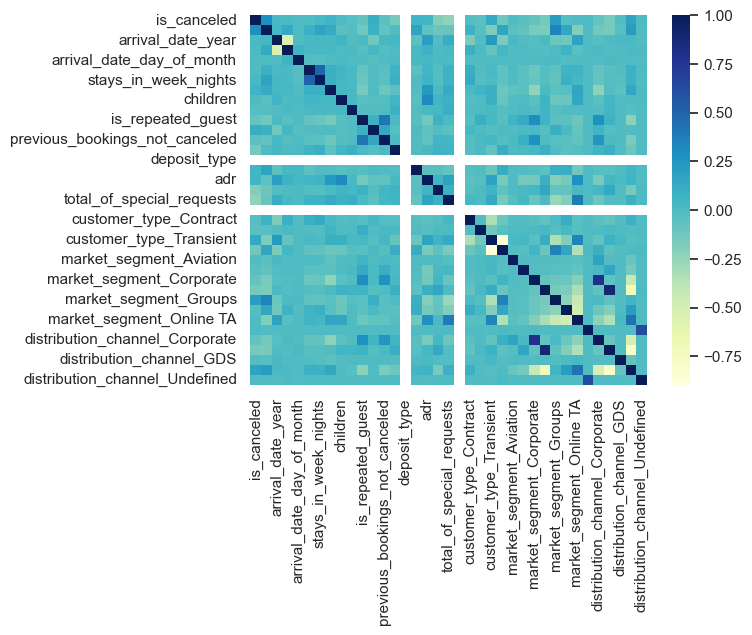

In [97]:
## Correlation Matrix Heatmap
sns.heatmap(data_hotel_bookings.corr(), cmap='YlGnBu')
plt.show()

Observations

High Positive Correlation:
- is_canceled & lead_time
- stays_in_weekend_nights & stays_in_week_nights
- is_repeated_guest & bookings_not_cancelled
- agent & company

Moderate Positive Correlation:
- arrival_date_year & company
- arrival_date_year & adr
- adults & company
- adults & adr
- children & adr
- total_of_special_requests & adr

Moderate Negative Correlation:
- is_cancelled & total_of_special_requests
- is_cancelled & required_car_parking_spaces
- is_repeated_guest & company
- arrival_date_week_number & arrival_date_year
- is_repeated_guest & adr

In [98]:
## Feature Importance
corr_adr = data_hotel_bookings.corr()["adr"]
corr_adr.abs().sort_values(ascending = False)

/var/folders/g_/02jbqh790tj4qzrwy17x87c00000gn/T/ipykernel_51308/3397052556.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_adr = data_hotel_bookings.corr()["adr"]


adr                               1.000000
children                          0.324853
market_segment_Online TA          0.288090
adults                            0.230641
arrival_date_year                 0.197580
market_segment_Groups             0.197279
customer_type_Transient           0.177905
total_of_special_requests         0.172185
customer_type_Transient-Party     0.160866
distribution_channel_Corporate    0.156556
market_segment_Complementary      0.154939
market_segment_Offline TA/TO      0.144506
market_segment_Corporate          0.138425
is_repeated_guest                 0.134314
market_segment_Direct             0.092561
arrival_date_week_number          0.075791
previous_bookings_not_canceled    0.072144
previous_cancellations            0.065646
stays_in_week_nights              0.065237
lead_time                         0.063077
distribution_channel_TA/TO        0.061685
required_car_parking_spaces       0.056628
customer_type_Contract            0.053132
stays_in_we

Observations

Top 5 Feature Selection By Importance
1. children
2. adults
3. arrival_date_year
4. total_of_special_requests
5. is_repeated_guest

In [99]:
## Selecting Top 5 Features for Model Building
data_hotel_bookings_feature = data_hotel_bookings[['adr', 'children', 'adults', 'arrival_date_year', 'total_of_special_requests', 'is_repeated_guest']]
data_hotel_bookings_feature.drop(index = [row for row in data_hotel_bookings_feature.index if 0 >= data_hotel_bookings_feature.loc[row, 'adr']], inplace = True)
data_hotel_bookings_feature.dropna()
data_hotel_bookings_feature.head()

/var/folders/g_/02jbqh790tj4qzrwy17x87c00000gn/T/ipykernel_51308/3974446356.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hotel_bookings_feature.drop(index = [row for row in data_hotel_bookings_feature.index if 0 >= data_hotel_bookings_feature.loc[row, 'adr']], inplace = True)


,adr,children,adults,arrival_date_year,total_of_special_requests,is_repeated_guest
2,75.0,0.0,1,2015,0,0
3,75.0,0.0,1,2015,0,0
4,98.0,0.0,2,2015,1,0
5,98.0,0.0,2,2015,1,0
6,107.0,0.0,2,2015,0,0


### Model Selection

In [100]:
## Evaluation Function (with different Metrics)
def evaluation(y_test, y_pred):
    print("Accuracy: ", accuracy_score(y_test, y_pred))         # Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
    # print("Specificity: " (y_test, y_pred))                   # Proportion of Predicted No out of Actual No: (TN) / (FP + TN)
    print("Precision: ", precision_score(y_test, y_pred))       # Proportion of Actual Yes out of Predicted Yes: (TP) / (TP + FP)
    print("Sensitivity/Recall: ", recall_score(y_test, y_pred)) # Proportion of Predicted Yes out of Actual Yes: (TP) / (TP + FN)
    print("F1 Score: ", f1_score(y_test, y_pred))               # Balanced Index Between Precision & Sensitivity: (2 * Precision * Sensitivity) / (Precision + Sensitivity)
    print("Classification report: \n", classification_report(y_test, y_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title('Confusion Matrix For Given Prediction')
    plt.show()

In [101]:
## Splitting Data
x = data_hotel_bookings_feature.drop(columns = 'adr')
y = data_hotel_bookings_feature.adr
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, train_size=0.7, random_state=0)
x_train.shape,x_test.shape

((82201, 5), (35229, 5))

In [102]:
## Model 1: Naive Bayes (using GNB Technique)
# Assumes each parameter (Feature) has an independent capacity of predicting output variable

gnb = GaussianNB()
gnb_model = gnb.fit(x_train, y_train)
gnb_y_pred = gnb_model.predict(x_test)
gnb_cm = ConfusionMatrix(gnb)
gnb_cm.fit(x_train, y_train)
gnb_cm.score(x_test, y_test)

ValueError: Unknown label type: (array([2.600e-01, 5.000e-01, 1.000e+00, ..., 4.515e+02, 5.080e+02,
       5.100e+02]),)

In [38]:
## Model 2: Random Forest Classifier
# Combines output of multiple decision trees to reach a single result
rf = RandomForestClassifier()
rf_model = rf.fit(x_train, y_train)
rf_y_pred = rf_model.predict(x_test)
evaluation(y_train, rf_model.predict(x_train))

ValueError: Unknown label type: 'continuous'

In [114]:
# # Model 3: Logistic Regression

X = data_hotel_bookings.drop('is_canceled', axis=1)
y = data_hotel_bookings['is_canceled']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

ValueError: could not convert string to float: 'City Hotel'